In [1]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary


/home/buono/ObjDct_Repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Implement YOLO architecture

In [2]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1) + torch.pow(t,2)

class TinyissimoYOLO(nn.Module):
    def __init__(self, B=2, num_classes=1, S=4):
        super(TinyissimoYOLO, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 12, kernel_size=5, stride=2),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12*4*4, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 3 * B)),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # print(x.shape)
        x = self.fclayers(x)

        return x


model = TinyissimoYOLO()

summary(model, input_size=(1, 1, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLO                           [1, 112]                  --
├─Sequential: 1-1                        [1, 4, 21, 21]            --
│    └─Conv2d: 2-1                       [1, 4, 42, 42]            104
│    └─LinearActivation: 2-2             [1, 4, 42, 42]            --
│    └─AvgPool2d: 2-3                    [1, 4, 21, 21]            --
├─Sequential: 1-2                        [1, 12, 4, 4]             --
│    └─Conv2d: 2-4                       [1, 12, 9, 9]             1,212
│    └─LinearActivation: 2-5             [1, 12, 9, 9]             --
│    └─AvgPool2d: 2-6                    [1, 12, 4, 4]             --
├─Sequential: 1-3                        [1, 112]                  --
│    └─Flatten: 2-7                      [1, 192]                  --
│    └─Linear: 2-8                       [1, 256]                  49,408
│    └─LinearActivation: 2-9             [1, 256]                  --
│    └─

# Utility Functions

## Euclidean Distance between centers

In [3]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

## mAP

In [4]:
def is_center_inside_bbox(center, bbox):
    """
    Check if a center (x, y) is inside a bounding box (x, y, w, h).
    Parameters:
        center (tuple): The (x, y) coordinates of the center.
        bbox (tuple): The (x, y, w, h) coordinates of the bounding box.
    Returns:
        bool: True if the center is inside the bounding box, False otherwise.
    """
    center_x, center_y = center
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    bbox_x_min = bbox_x - bbox_w / 2
    bbox_x_max = bbox_x + bbox_w / 2
    bbox_y_min = bbox_y - bbox_h / 2
    bbox_y_max = bbox_y + bbox_h / 2

    return bbox_x_min <= center_x <= bbox_x_max and bbox_y_min <= center_y <= bbox_y_max


def mean_average_precision(
    pred_boxes, true_boxes, num_classes=1
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bbox
        specified as [train_idx, class_prediction, prob_score, x_center, y_center]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        specified as [train_idx, class_label, x, y, w, h]
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_match = False

            for idx, gt in enumerate(ground_truth_img):
                if is_center_inside_bbox(detection[3:5], gt[2:]):
                    best_match = True
                    best_gt_idx = idx
                    break

            if best_match:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



## NMS

In [5]:
def non_max_suppression(centers):

    assert type(centers) == list
    # centers = [center for center in centers if center[1]> threshold]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)
        centers_after_nms.append(current_center)
        break

    return centers_after_nms


## Get and convert centers

In [6]:
def get_bboxes(
    loader,
    model,
    device,
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)


        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) # type: ignore
        pred_centers = cellcenters_to_centers(predictions) # type: ignore



        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            nms_centers= non_max_suppression(
                pred_centers[idx]
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            # for center in pred_centers[idx]:
            #     if center[1] > 0:
            #         all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    model.train()
    return all_pred_centers, all_true_centers, all_true_boxes


def convert_cellcenters(predictions, S=4, C=1):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]

    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )

    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

def cellcenters_to_centers(out, S=4):
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)

    return all_centers


# Create Loader of Dataset

In [7]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [8]:
class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("L")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])

        if len(boxes) > 3:
            boxes = boxes[:3]
            centers = centers[:3]

        boxes = torch.tensor(boxes)
        centers = torch.tensor(centers)
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1

        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

# YOLO Loss

In [9]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        iou_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        ious = torch.cat([iou_c1.unsqueeze(0), iou_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestcenter = torch.max(ious, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# Training

In [10]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", DEVICE)
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 25


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y,boxes) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss = loss.item())

    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

DEVICE:  cpu


In [11]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list


In [12]:
files_dir = '/home/buono/ObjDct_Repo/data/ShipDataset'
loss_fn = YoloLoss()

In [13]:
train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=True
)

test_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=False
)
# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [ ]:
model = TinyissimoYOLO().to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model, optimizer, loss_fn)
    # pred_boxes, target_boxes, real_boxes = get_bboxes(
    #     train_loader, model, threshold=0.4, distance_threshold=0.1, device=DEVICE
    # )
    # mAP = mean_average_precision(pred_boxes, real_boxes)
    # print(f"mAP: {mAP}")

In [ ]:
torch.save(model.state_dict(), "../../models/trained_models/LeNetYOLO.pth")

## Create other 2 models for ensemble

In [ ]:
model_1 = TinyissimoYOLO().to(DEVICE)
optimizer = optim.Adam(
    model_1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model_1, optimizer, loss_fn)
    
torch.save(model_1.state_dict(), "../../models/trained_models/LeNetYOLO_1.pth")

In [ ]:
model_2 = TinyissimoYOLO().to(DEVICE)
optimizer = optim.Adam(
    model_2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_fn(train_loader, model_2, optimizer, loss_fn)
    
torch.save(model_2.state_dict(), "../../models/trained_models/LeNetYOLO_2.pth")

# Ensemble

## Load Models

In [14]:
models = []
model = TinyissimoYOLO()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO.pth")
model.load_state_dict(checkpoint)
model.eval()
models.append(model)

model_1 = TinyissimoYOLO()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_1.pth")
model_1.load_state_dict(checkpoint)
model_1.eval()
models.append(model_1)

model_2 = TinyissimoYOLO()
checkpoint = torch.load("../../models/trained_models/LeNetYOLO_2.pth")
model_2.load_state_dict(checkpoint)
model_2.eval()
models.append(model_2)


## Create average predictions

In [15]:
pred_boxes_list = []
with torch.no_grad():
    pred_boxes_1, target_boxes, real_boxes_1 = get_bboxes(
        test_loader, model, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_1, real_boxes_1)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_1)

    pred_boxes_2, target_boxes, real_boxes_2 = get_bboxes(
        test_loader, model_1, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_2, real_boxes_2)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_2)

    pred_boxes_3, target_boxes, real_boxes_3 = get_bboxes(
        test_loader, model_2, DEVICE
    )
    mAP = mean_average_precision(pred_boxes_3, real_boxes_3)
    print(f"mAP: {mAP}")
    pred_boxes_list.append(pred_boxes_3)


mAP: 0.2573724091053009
mAP: 0.33541443943977356
mAP: 0.32933834195137024


In [16]:
pred_boxes_list = np.array(pred_boxes_list)
pred_boxes_list.shape

(3, 7946, 5)

In [17]:
def ensemble_center_predictions(predictions):
    """
    Ensemble predictions from multiple models by averaging center coordinates and confidence scores.

    Parameters:
        predictions (numpy.ndarray): Array of shape (num_models, num_predictions, 5) containing
                                     the predictions from each model. Each prediction is in the
                                     format [predicted_class, best_confidence, x_center, y_center].
        
    Returns:
        numpy.ndarray: Array of ensemble predictions.
    """
    def average_predictions(predictions):
        # Average center coordinates and confidence scores
        class_ids = predictions[:, 0]
        avg_confidences = np.mean(predictions[:, 1], axis=0)
        avg_centers = np.mean(predictions[:, 2:], axis=0)
        
        return np.array([class_ids[0], avg_confidences, *avg_centers])
    
    all_predictions = []
    
    for i in range(predictions.shape[1]):  # Iterate over each prediction index
        single_prediction = predictions[:, i, :]
        ensembled_prediction = average_predictions(single_prediction)
        all_predictions.append(ensembled_prediction)
    
    return np.array(all_predictions)

# Example usage
predictions = np.random.rand(2, 7946, 5)  # Example array with predictions
ensembled_predictions = ensemble_center_predictions(predictions)
print(ensembled_predictions.shape)


(7946, 5)


In [18]:
ensembled_predictions = ensemble_center_predictions(pred_boxes_list)
mAP = mean_average_precision(ensembled_predictions, real_boxes_1)
print(f"mAP: {mAP}")

mAP: 0.32880884408950806


In [19]:
real_boxes_1 = np.array(real_boxes_1)
real_boxes_2 = np.array(real_boxes_2)
real_boxes_3 = np.array(real_boxes_3)


# Testing

In [ ]:
checkpoint = torch.load("../../models/trained_models/LeNetYOLO.pth")
# Load the state dictionary from the .pth file

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Ensure the model is in evaluation mode
model.eval()


with torch.no_grad():
    pred_boxes, target_boxes, real_boxes = get_bboxes(
        test_loader, model, DEVICE
    )
    mAP = mean_average_precision(pred_boxes, real_boxes)
    print(f"mAP: {mAP}")


In [ ]:
pred_boxes[:5]

## Plot test results and statistics

In [ ]:
def plot_centers(idx, pred_centers, target_centers):
    values = test_dataset[idx]
    image = values[0]
    image = image.permute(1, 2, 0).to("cpu")

    image = np.array(image)
    height, width, _ = image.shape
    p_centers = []
    t_centers = []
    for center in pred_centers:
        if center[0] == idx:
            p_centers.append(center[1:])

    for center in target_centers:
        if center[0] == idx:
            t_centers.append(center[1:])


    fig, ax = plt.subplots()
    ax.imshow(image)
    for center in p_centers:
        rect = patches.Rectangle(
            (center[2] * width , center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    # Create a Rectangle patch
    for boxes in t_centers:
        class_label = int(boxes[0])
        box = boxes[1:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class label text
        ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')


    plt.show()

plot_centers(4, ensembled_predictions, real_boxes)

([<matplotlib.axis.XTick at 0x720342f4bad0>,
 [Text(0.0, 0, 'Very Small'),
  Text(0.1, 0, 'Small'),
  Text(0.15, 0, 'Medium'),
  Text(0.2, 0, 'Large'),
  Text(0.25, 0, 'Very Large')])

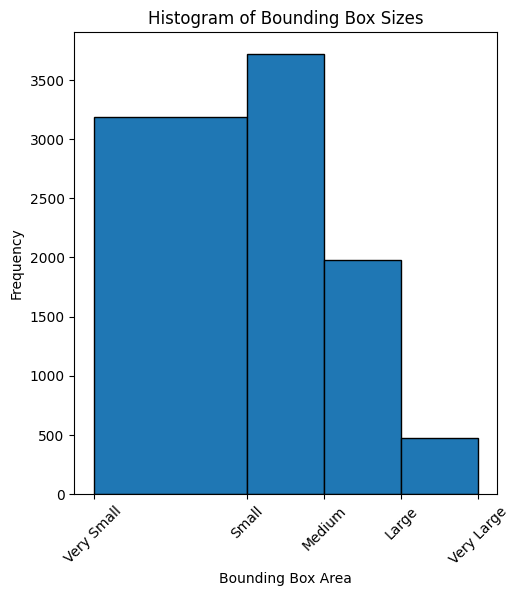

In [24]:
bounding_boxes = np.array(real_boxes_1)[:,2:]
bounding_boxes

areas = np.sqrt([width * height for (x_center, y_center, width, height) in bounding_boxes])

# Raggruppamento delle bounding box per dimensione
bins = [0, 0.1, 0.15, 0.2, 0.25]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
box_sizes = np.digitize(areas, bins=bins, right=True)

# Creazione dell'istogramma delle dimensioni delle bounding box
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(areas, bins=bins, edgecolor='black')
plt.title('Histogram of Bounding Box Sizes')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.xticks(ticks=bins, labels=labels, rotation=45)


## Ensemble Distances

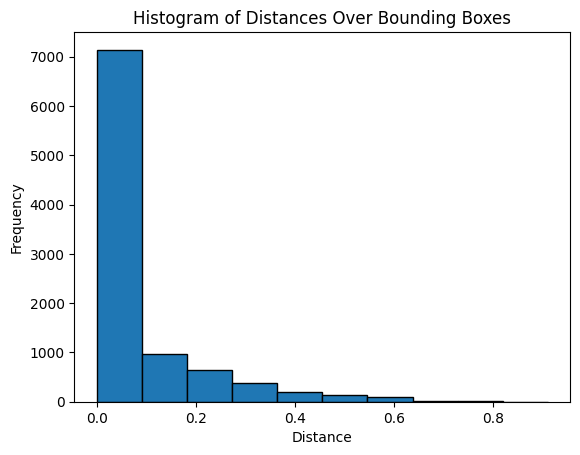

In [25]:
# Calcolo delle distanze minime
distances = []

#for (idx_p,_,_, x_p, y_p), (idx_b,_, x_center, y_center, width, height) in zip(pred_boxes, real_boxes):
for idx_p, _ ,_ ,x_p, y_p in ensembled_predictions:
  for idx_b,_, x_center, y_center, width, height in real_boxes_1:
    if idx_p == idx_b:
      x_left = x_center - width / 2
      x_right = x_center + width / 2
      y_top = y_center - height / 2
      y_bottom = y_center + height / 2

      dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
      dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
      dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
      dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

      # Se il punto è all'interno della bounding box, la distanza è zero
      if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
          min_distance = 0
      else:
          min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

      distances.append(min_distance)

plt.hist(distances, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Over Bounding Boxes')
plt.show()


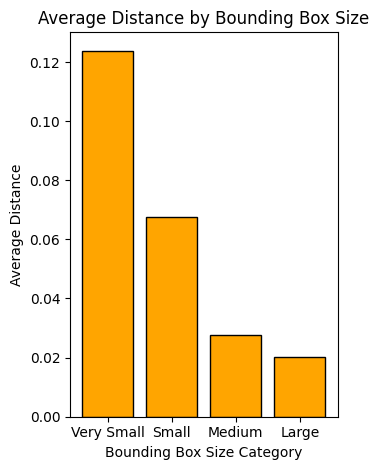

In [26]:
# Calcolo della distanza media per ciascun gruppo di dimensioni
distance_means = []
for i in range(len(bins) - 1):
    group_distances = [dist for dist, size in zip(distances, box_sizes) if size == i + 1]
    if group_distances:
        distance_means.append(np.mean(group_distances))
    else:
        distance_means.append(0)

labels = ['Very Small', 'Small', 'Medium', 'Large']
# Creazione del grafico delle distanze medie per categoria di dimensione
plt.subplot(1, 2, 2)
plt.bar(labels, distance_means, color='orange', edgecolor='black')
plt.title('Average Distance by Bounding Box Size')
plt.xlabel('Bounding Box Size Category')
plt.ylabel('Average Distance')

plt.tight_layout()
plt.show()

# 3 networks

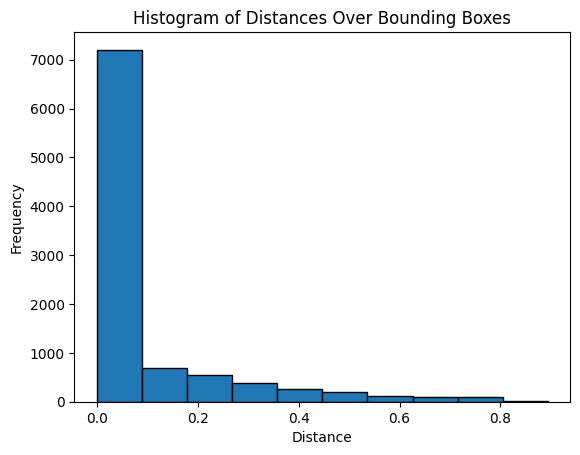

In [27]:
# Calcolo delle distanze minime
distances_1 = []

#for (idx_p,_,_, x_p, y_p), (idx_b,_, x_center, y_center, width, height) in zip(pred_boxes, real_boxes):
for idx_p, _ ,_ ,x_p, y_p in pred_boxes_1:
  for idx_b,_, x_center, y_center, width, height in real_boxes_1:
    if idx_p == idx_b:
      x_left = x_center - width / 2
      x_right = x_center + width / 2
      y_top = y_center - height / 2
      y_bottom = y_center + height / 2

      dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
      dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
      dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
      dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

      # Se il punto è all'interno della bounding box, la distanza è zero
      if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
          min_distance = 0
      else:
          min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

      distances_1.append(min_distance)

plt.hist(distances_1, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Over Bounding Boxes')
plt.show()


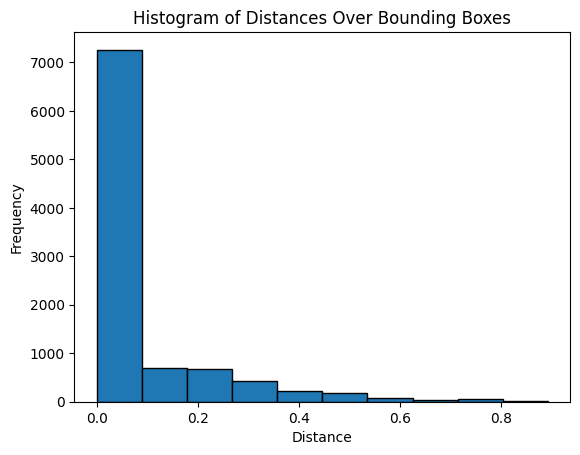

In [28]:
# Calcolo delle distanze minime
distances_2 = []

#for (idx_p,_,_, x_p, y_p), (idx_b,_, x_center, y_center, width, height) in zip(pred_boxes, real_boxes):
for idx_p, _ ,_ ,x_p, y_p in pred_boxes_2:
  for idx_b,_, x_center, y_center, width, height in real_boxes_2:
    if idx_p == idx_b:
      x_left = x_center - width / 2
      x_right = x_center + width / 2
      y_top = y_center - height / 2
      y_bottom = y_center + height / 2

      dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
      dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
      dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
      dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

      # Se il punto è all'interno della bounding box, la distanza è zero
      if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
          min_distance = 0
      else:
          min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

      distances_2.append(min_distance)

plt.hist(distances_2, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Over Bounding Boxes')
plt.show()

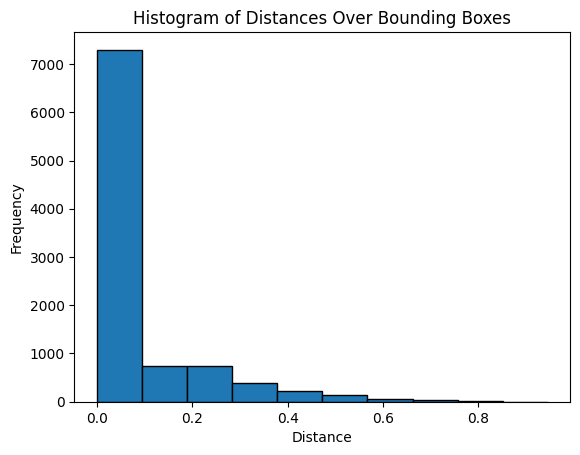

In [29]:
# Calcolo delle distanze minime
distances_3 = []

#for (idx_p,_,_, x_p, y_p), (idx_b,_, x_center, y_center, width, height) in zip(pred_boxes, real_boxes):
for idx_p, _ ,_ ,x_p, y_p in pred_boxes_3:
  for idx_b,_, x_center, y_center, width, height in real_boxes_3:
    if idx_p == idx_b:
      x_left = x_center - width / 2
      x_right = x_center + width / 2
      y_top = y_center - height / 2
      y_bottom = y_center + height / 2

      dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
      dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
      dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
      dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

      # Se il punto è all'interno della bounding box, la distanza è zero
      if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
          min_distance = 0
      else:
          min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

      distances_3.append(min_distance)

plt.hist(distances_3, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Over Bounding Boxes')
plt.show()

In [30]:
# Calcolo della distanza media per ciascun gruppo di dimensioni
distance_means = []
for i in range(len(bins) - 1):
    group_distances = [dist for dist, size in zip(distances, box_sizes) if size == i + 1]
    if group_distances:
        distance_means.append(np.mean(group_distances))
    else:
        distance_means.append(0)

In [31]:
# Calcolo della distanza media per ciascun gruppo di dimensioni
distance_means_1 = []
for i in range(len(bins) - 1):
    group_distances = [dist for dist, size in zip(distances_1, box_sizes) if size == i + 1]
    if group_distances:
        distance_means_1.append(np.mean(group_distances))
    else:
        distance_means_1.append(0)

In [32]:
# Calcolo della distanza media per ciascun gruppo di dimensioni
distance_means_2 = []
for i in range(len(bins) - 1):
    group_distances = [dist for dist, size in zip(distances_2, box_sizes) if size == i + 1]
    if group_distances:
        distance_means_2.append(np.mean(group_distances))
    else:
        distance_means_2.append(0)

In [33]:
# Calcolo della distanza media per ciascun gruppo di dimensioni
distance_means_3 = []
for i in range(len(bins) - 1):
    group_distances = [dist for dist, size in zip(distances_3, box_sizes) if size == i + 1]
    if group_distances:
        distance_means_3.append(np.mean(group_distances))
    else:
        distance_means_3.append(0)

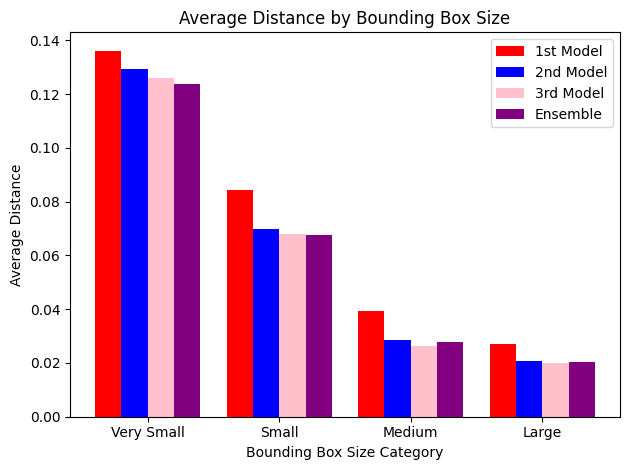

In [34]:
# Creiamo una lista di etichette per le categorie di dimensioni
labels = ['Very Small', 'Small', 'Medium', 'Large']

# Configuriamo il numero di gruppi e il numero di barre per gruppo
x = np.arange(len(labels))
width = 0.2  # Larghezza delle barre

fig, ax = plt.subplots()

# Aggiungiamo le barre per ogni set di distance_means
rects1 = ax.bar(x - 1.5 * width, distance_means_1, width, label='1st Model', color='red')
rects2 = ax.bar(x - 0.5 * width, distance_means_2, width, label='2nd Model', color='blue')
rects3 = ax.bar(x + 0.5 * width, distance_means_3, width, label='3rd Model', color='pink')
rects4 = ax.bar(x + 1.5 * width, distance_means, width, label='Ensemble', color='purple')

# Aggiungiamo le etichette, il titolo e la legenda
ax.set_xlabel('Bounding Box Size Category')
ax.set_ylabel('Average Distance')
ax.set_title('Average Distance by Bounding Box Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Aggiungiamo una disposizione più compatta
fig.tight_layout()

plt.show()